# Deep Reiforcement Learning

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import os
from tqdm.notebook import tqdm


import torch
from torch import nn
from torch import optim

import gym

from collections import deque, OrderedDict

## Enable gym environment rendering in Colab

> This section is not required if you are executing the notebook in a local environment. It enables the video generation from Gym environments, and it is only required in Colab since we do not have access to a screen.

Source: https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

In [ ]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

In [ ]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './videos', force=True, video_callable=video_callable)
  return env

## Enable video saving in the local machine

In [ ]:
from gym.wrappers.monitoring import video_recorder

class EnvWrapper():
  '''
  There is bugin the gym code that doesn't allow the proper usage of gym.wrappers.Monitor
  This class allows saving a video of the agent's behavior when using the local machine, by extending some functione of the gym environment.
  
  Agrs:
    env: gym environment
    video_path: string, where to save the video

  '''

  def __init__(self, env, video_path):
    self.env = env
    self.vid = video_recorder.VideoRecorder(self.env,path=video_path)

  def close(self):
    self.vid.close()
    return self.env.close()

  def reset(self):
    return self.env.reset()

  def seed(self, seed):
    return self.env.seed(seed)

  def step(self, *args, **kwargs):
    return self.env.step(*args, **kwargs)

  def render(self, mode='human'):
    r = self.env.render(mode)
    self.vid.capture_frame()
    return r

## Composing the agent

### Replay Memory

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, next_state, reward):
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

### Policies


Here follows a bunch of possible policies for the agent. All must take as arguments the q values and a generic beta parameter which can be the temperature for the softmax policy or epsilon for the epsilon greedy policy

In [ ]:
def random_policy(q_values, beta):
  '''
  Args:
    q_values: array like
    beta: float, ignored

  Returns a random value from 0 to len(q_values) - 1
  '''
  return np.random.randint(q_values.shape[-1])


def greedy_policy(q_values, beta):
  '''
  Args:
    q_values: array like
    beta: float, ignored

  Returns the argmax of q_values
  '''
  return int(q_values.argmax())


def epsilon_greedy_policy(q_values, beta):
  '''
  Args:
    q_values: array like
    beta: float, epsilon

  Returns:
    with probability 1 - epsilon the greedy action
    with probability epsilon a random non optimal action
  '''
  if beta < 0 or beta > 1:
    raise ValueError(f'epsilon must be in [0,1], not {beta}')

  best_action = int(q_values.argmax())

  if random.random() < beta:
    non_optimal_actions = [a for a in range(q_values.shape[-1]) if a != best_action]
    return np.random.choice(non_optimal_actions)
  
  return best_action


def softmax_policy(q_values, beta):
  '''
  Args:
    q_values: array like
    beta: float, temperature of the softmax

  Returns:
    'a' with probability proportional to exp(q_values[a]/beta)
  '''
  if beta < 0:
    raise ValueError(f'temperature must be >= 0, not {beta}')
  if beta == 0:
    return greedy_policy(q_values, beta)

  beta = max(beta, 1e-8) # for numerical stability
  softmax_out = nn.functional.softmax(q_values/beta, dim=0).cpu().numpy()

  return np.random.choice(np.arange(softmax_out.shape[-1]), p=softmax_out)

### Networks

In [ ]:
class FCN(nn.Module):
  '''
  Fully connencted network

  Args:
    Ni: input neurons
    Nhs: list of neurons of the hidden layers
    No: output neurons
    activation_function: default nn.ReLU (beware not nn.ReLU() !!)
    o_act: activation function after the output layer, default nn.Identity()
  '''
  def __init__(self, Ni, Nhs=None, No=10, activation_function=nn.ReLU, o_act=nn.Identity()):
    super().__init__()

    self.od = OrderedDict({})
    self.shapes = [Ni]
    if Nhs is not None and len(Nhs) > 0:
      self.shapes += Nhs

    for i,s in enumerate(self.shapes[:-1]):
      self.od.update({f'lin{i+1}': nn.Linear(s, self.shapes[i+1])})
      self.od.update({f'lin_act{i+1}': activation_function()})
    
    self.od.update({'out': nn.Linear(self.shapes[-1], No)})
    self.shapes.append(No)

    self.lin_layers = nn.Sequential(self.od)

    self.o_act = o_act

    print('FCN initialized')
    print('Shape flow: ', self.shapes)

  def forward(self, x):
    x = self.o_act(self.lin_layers(x))
    return x



class CNN(nn.Module):
  '''
  Convolutional layers followed by linear layers

    Params of the convolutional layers: the following should be lists of int and be of the same lenght
      channels
      kernel_sizes
      strides
      paddings

    Params of the linear layers:
      Nhs: list of int: numbers of neurons per linear layer
      No: number of output neurons
    
    Activation functions:
      activation_function: default nn.ReLU (beware NOT nn.ReLU()): activation function between all the hidden layers
      o_act: default nn.Identity(): activation function after the output layer
  '''
  def __init__(self, channels=[], kernel_sizes=[], strides=[], paddings=[], Nhs=[], activation_function=nn.ReLU, No=10, o_act=nn.Identity(), input_shape=(1, 28, 28)):
    super().__init__()

    self.shapes = [input_shape]

    ### Convolutional layer

    ## Create an ordered dictionary with the layers
    self.conv_od = OrderedDict([])
    for i,c in enumerate(channels):
      # add convolutional layer
      if i == 0:
        self.conv_od.update({'conv1': nn.Conv2d(in_channels=self.shapes[0][0],out_channels=channels[0],
                                                       kernel_size=kernel_sizes[0], stride = strides[0], padding=paddings[0])})
      else:
        self.conv_od.update({f'conv{i + 1}': nn.Conv2d(in_channels=channels[i - 1],out_channels=c,
                                                       kernel_size=kernel_sizes[i], stride = strides[i], padding=paddings[i])})
      next_size_1 = (self.shapes[-1][1] + 2*paddings[i] - kernel_sizes[i])//strides[i] + 1
      next_size_2 = (self.shapes[-1][2] + 2*paddings[i] - kernel_sizes[i])//strides[i] + 1
      self.shapes.append((c, next_size_1, next_size_2))
      if next_size_1 < 1 or next_size_2 < 1:
        raise TypeError(f'Shape flow interrupted: {self.shapes}')
      # add activation function
      self.conv_od.update({f'conv_act{i + 1}': activation_function()})

    ## Create a sequential layer
    self.conv_layers = nn.Sequential(self.conv_od)


    ### Flatten

    self.flatten = nn.Flatten(start_dim=1)
    self.shapes.append(np.product(self.shapes[-1]))


    ### Linear fc layers

    ## Create ordered dictionary with the layers
    self.lin_od = OrderedDict([])
    _Nhs = [self.shapes[-1]] + Nhs
    for i in range(1,len(_Nhs)):
      # add linear layer
      self.lin_od.update({f'lin{i}': nn.Linear(in_features=_Nhs[i - 1], out_features=_Nhs[i])})
      self.shapes.append(_Nhs[i])

      # add activation function
      self.lin_od.update({f'lin_act{i}': activation_function()})

    ## Create a sequential layer
    self.lin_layers = nn.Sequential(self.lin_od)


    ## Create the output layer
    self.out = nn.Linear(in_features=_Nhs[-1], out_features=No)
    self.o_act = o_act
    self.shapes.append(No)

    print('CNN initialized\nShape flow: ',self.shapes)

  def forward(self, x):
    # apply convolutional layers
    x = self.conv_layers(x)

    # flatten
    x = self.flatten(x)

    # apply linear layers
    x = self.lin_layers(x)

    # output layer
    x = self.o_act(self.out(x))
    return x

### Agent

In [ ]:
def default_modifier(agent):
  '''
  Adds 1 to the agent's score
  '''
  agent.score += 1
  return

class Agent():
  '''
  Class for handling the interaction with a gym environment

  Args:
    env: gym environment
    policy_net: neural network
    policy: one of the policy functions in the section 'Policies'
    screen_preprocesser: class for preprocessing the screen pixels, if None (default) the high level information is used, otherwise the pixels are used
    choose_action_every: int (default 1): number of steps every which to choose which action to take, when the action is not chosen the previous one is repeated.
  '''

  def __init__(self, env, policy_net, policy=None, screen_preprocesser=None, choose_action_every=1):
    self.env = env
    self.policy_net = policy_net
    self.policy = policy

    self.screen_preprocesser = screen_preprocesser
    self.choose_action_every = choose_action_every

    self.score = 0
    self.cumulated_reward = 0
    self.t = 0

    self.reward = 0
    self.state = None

    self.aux_state = None # is the normal state when using pixels
    self.aux_next_state = None

    self.action = None
    self.next_state = None
    self.q_values = None

    self.is_ready = False

  def run_episode(self, beta=0, max_score=500, min_score=-np.infty, modifier=default_modifier, render=False, fps=None, debug=False, verbose=True):
    '''
    Runs a single episode on the environment.

    Args:
      beta: float (default 0): parameter for the policy
      max_score: (default 500)
      min_score: (default -np.infty):
        stop interaction with the environment when score >= max_score or score <= min_score
      modifier: function
        modifies the reward and the score of the agent and takes care of optimizing the policy net parameters and to push samples to the replay memory

      render: bool (default False):
        wheteher to render the environment: set to False to speed up the process
      fps: float (default None):
        frames per second of the rendered video. If None the video is rendered as fast as possible

      debug: bool (default False):
        if true the function returns the observed states and computed qvalues during the episode.

      verbose: bool (default True)
    '''
    if debug:
      states = []
      qvalues = []

    self.t = 0
    self.score = 0
    self.cumulated_reward = 0
    self.q_values = torch.zeros(self.policy_net.shapes[-1], dtype=torch.float32)
    self.action = random_policy(self.q_values, 0) # select first action randomly in case the agent cannot evaluate the policy net
    done = False

    if self.screen_preprocesser is not None: # we are using pixels
      self.aux_state = self.env.reset()
      self.state = self.screen_preprocesser(self.env.render(mode='rgb_array'))
    else:
      self.state = self.aux_state = self.env.reset()

    while not done and self.score < max_score and self.score > min_score:
      try:
        if self.t % self.choose_action_every == 0:
          # compute q values
          self.policy_net.eval()
          with torch.no_grad():
            if self.screen_preprocesser is not None: # we are using pixels
              self.q_values = self.policy_net(self.state.unsqueeze(0)).squeeze()
            else:
              self.q_values = self.policy_net(torch.tensor(self.state, dtype=torch.float32))
            if debug:
              states.append(self.state)
              qvalues.append(self.q_values)
          # choose action
          self.action = self.policy(self.q_values, beta)
          self.is_ready = True
      except KeyboardInterrupt:
        raise KeyboardInterrupt
      except:
        self.is_ready = False
        self.action = random_policy(self.q_values, 0) # select first action randomly in case the agent cannot evaluate the policy net
        if verbose and debug:
          print('Cannot evaluate policy net')

      # apply action
      self.next_state, self.reward, done, info = self.env.step(self.action)
      if self.screen_preprocesser is not None: # we are using pixels
        self.aux_next_state = np.copy(self.next_state)
        self.next_state = self.screen_preprocesser(self.env.render(mode='rgb_array'))
      else:
        self.aux_next_state = self.next_state


      if done:
        self.next_state = None

      # call the modifier
      modifier(self)

      # update cumulated reward
      self.cumulated_reward += self.reward

      # render the environment
      if render:
        self.env.render()
        if fps is not None:
          time.sleep(1./fps)
      
      self.state = self.next_state
      self.aux_state = self.aux_next_state

      self.t += 1

    if verbose:
      print(f'final score: {self.score}')
    if debug:
      return states, qvalues

### Evolver

In [ ]:
class Evolver():
  '''
  Class for training an agent.

  Args:
    agent: Agent
    target_net: net to be used for computing expected Q-values.
    update_target_net_every: int (default 10):
      number of episodes every which to update the target net

    optimizer_type: e.g. optim.SGD
    optimizer_params: dictionary
    loss_function: e.g. nn.MSELoss()

    memory_capacity: int (default 10000):
      maximum number of samples for the replay memory
    min_samples: int (default 1000):
      minimum number of samples in the replay memory to start training the agent
    batch_size: int (default 256)

    discount_rate: float (default 0.97)

    gradient_clip_value: float (default 2):
      Clips the norm of the gradient of the weight of the training net

    score_to_beat: float (default 500):
      minimum score by the agent at the end of an episode for considering the game beaten


    device: GPU or CPU: default None, i.e. CPU
  '''

  def __init__(self, agent, target_net, optimizer_type, optimizer_params, loss_function, 
               memory_capacity=10000, min_samples=1000, batch_size=256,
               discount_rate=0.97, gradient_clip_value=2,
               score_to_beat=500, update_target_net_every=10, device=None):
    
    self.agent = agent
    self.target_net = target_net
    self.target_net.load_state_dict(self.agent.policy_net.state_dict())

    self.optimizer = optimizer_type(self.agent.policy_net.parameters(), **optimizer_params)

    self.loss_function = loss_function

    self.replay_mem = ReplayMemory(memory_capacity)
    self.min_samples = min_samples
    self.batch_size = batch_size

    self.discount_rate = discount_rate
    self.gradient_clip_value = gradient_clip_value

    self.device = device

    self.episode_num = 0
    self.perfect_consecutive_episodes = 0

    self.score_to_beat = score_to_beat
    self.update_target_net_every = update_target_net_every

    self.score_log = []
    self.cumulated_reward_log = []

  def __len__(self):
    return len(self.score_log)

  def modify_reward(self, agent):
    # simply modify the score, no penalties or bonuses to the reward
    agent.score += 1


  def modifier(self, agent):
    '''
    Function that is passed to agent.run_episode
    '''
    # modify the reward of the agent: e.g. add penalties
    self.modify_reward(agent)

    # add new samples to the replay memory
    self.replay_mem.push(agent.state, agent.action, agent.next_state, agent.reward)
    if len(self.replay_mem) == self.min_samples:
      print('\n\nInitiating learning\n\n')
    if len(self.replay_mem) > self.min_samples:
      # update policy net
      self.update_step()


  def update_target_net(self, verbose=False):
    if self.episode_num % self.update_target_net_every == 0:
      if verbose:
        print('Updating target net')
      self.target_net.load_state_dict(self.agent.policy_net.state_dict())


  def evolve(self, beta_profile, verbose=False, min_perfect_episodes=10, render_every=0, fps=None, max_score=500, min_score=-np.infty):
    '''
    Evolves the agent:

    Args:
      beta_profile: ExplorationProfile instance. Learning will last at most len(beta_profile) episodes
      verbose: bool (default False)
      min_perfect_episodes: int (default 10):
        when the agent beats the game for min_perfect_episodes consecutive episodes learning stops.

      render_every: int (default 0):
        number of episodes every which to render the environment. If 0 the environment is never rendered.

      Parameters that are simply passed to agent.run_episode:
        fps
        max_score
        min_score
    '''
    if self.device is not None:
      self.agent.policy_net.to(self.device)
      self.target_net.to(device)

    while self.episode_num < len(beta_profile):
      beta = beta_profile[self.episode_num]
      if verbose:
        print(f'Episode {self.episode_num}: beta = {beta :.3e}, ',end='')


      # decide whether to render the environment
      if render_every == 0:
        render = False
      elif self.episode_num % render_every == 0:
        render = True
      else:
        render = False

      # run an episode
      self.agent.run_episode(beta=beta, max_score=max_score, min_score=min_score, modifier=self.modifier, render=render, fps=fps, verbose=verbose)

      # update target net
      self.update_target_net(verbose=verbose)

      # check if the agent beated the game
      if self.agent.score >= self.score_to_beat:
        self.perfect_consecutive_episodes += 1
      else:
        self.perfect_consecutive_episodes = 0

      self.episode_num += 1
      self.score_log.append(self.agent.score)
      self.cumulated_reward_log.append(self.agent.cumulated_reward)

      # update the beta profile
      beta_profile.update(self)

      # stop updating if the agent consistently beats the game
      if self.perfect_consecutive_episodes == min_perfect_episodes:
        if verbose:
          print('\n\n Game consistently beaten')
        break

  
  def update_step(self):
    '''
    Updates the policy net of the agent
    '''

    # Sample the data from the replay memory
    batch = self.replay_mem.sample(self.batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    if self.agent.screen_preprocesser is not None:
      states                = torch.stack([s[0] for s in batch])
      non_final_next_states = torch.stack([s[2] for s in batch if s[2] is not None])
    else:
      states                = torch.tensor([s[0] for s in batch], dtype=torch.float32)
      non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended

    actions                 = torch.tensor([s[1] for s in batch], dtype=torch.int64, device=self.device)
    rewards                 = torch.tensor([s[3] for s in batch], dtype=torch.float32, device=self.device)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool, device=self.device)

    # Compute all the Q values (forward pass)
    self.agent.policy_net.train()
    q_values = self.agent.policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      self.target_net.eval()
      q_values_target = self.target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size, device=self.device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * self.discount_rate)
    # Set the required tensor shape
    expected_state_action_values = expected_state_action_values.unsqueeze(1)

    # Compute the Huber loss
    loss = self.loss_function(state_action_values, expected_state_action_values)

    # Optimize the model
    self.optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (for training stability)
    if self.gradient_clip_value > 0:
      nn.utils.clip_grad_norm_(self.agent.policy_net.parameters(), self.gradient_clip_value)
    self.optimizer.step()

    del loss
    del q_values
    del state_action_values
    torch.cuda.empty_cache()

### Exploration profile

In [ ]:
class ExplorationProfile():
  '''
  Base class for scheduling the value of the beta parameter to be used in the policy
  '''

  def __init__(self,profile):
    self.profile = profile

  def __len__(self):
    return len(self.profile)

  def __getitem__(self, idx):
    return self.profile[idx]

  def update(self, evolver):
    '''
    In this base version does nothing
    '''
    return

  def plot(self):
    plt.figure(figsize=(12,8))
    plt.plot(self.profile)
    plt.grid()
    plt.xlabel('Iteration')
    plt.ylabel('Exploration profile')


class LinExplorationProfile(ExplorationProfile):
  '''
  Beta decays linearly from 'start_value' to 'end_value' over the first 'delta' episodes, then remains at 'end_value'.
  '''

  def __init__(self, max_iterations=1000, start_value=1, end_value=0, delta=300):
    self.profile = [start_value]
    self.max_iterations = max_iterations
    self.end_value = end_value
    self.delta = delta

  def __len__(self):
    return self.max_iterations

  def update(self, evolver):
    if len(self.profile) < self.max_iterations:
      if len(self.profile) < self.delta:
        new_value = self.profile[0] + (self.end_value - self.profile[0])/self.delta*len(self.profile)
      else:
        new_value = self.end_value

      self.profile.append(new_value)


class ExpExplorationProfile(ExplorationProfile):
  '''
  Beta decays exponentially from 'start_value' to 'start_value'*exp(-'lam') over 'max_iterations' episodes.
  '''

  def __init__(self, max_iterations=1000, start_value=1, lam=10):
    
    exp_decay = np.exp(-lam/max_iterations)
    self.profile = [start_value * (exp_decay ** i) for i in range(max_iterations)]

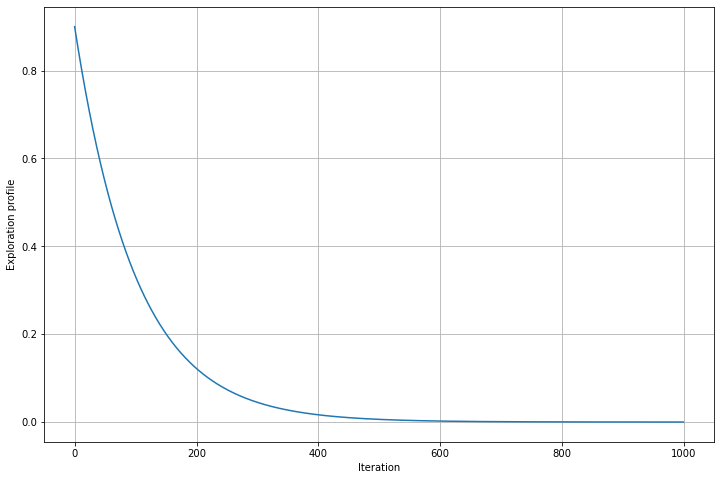

In [ ]:
exploration_profile = ExpExplorationProfile(start_value=0.9)

exploration_profile.plot()

## Cart-Pole

In [ ]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

env.close()

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


### Test

#### Random agent

In [ ]:
policy_net = FCN(Ni=state_space_dim,No=action_space_dim)
agent = Agent(env,policy_net,policy=random_policy)

FCN initialized
Shape flow:  [4, 2]


In [ ]:
agent.run_episode(render=True, fps=3)

final score: 13


In [ ]:
env.close()

#### Actually evolving

In [ ]:
net_params = {'Ni': state_space_dim, 'Nhs': [128, 128], 'No': action_space_dim, 'activation_function': nn.Tanh}

policy_net = FCN(**net_params)
target_net = FCN(**net_params)

agent = Agent(None,policy_net,policy=softmax_policy) # for now set the env to None

evolver_params = {'agent': agent, 'target_net': target_net, 'optimizer_type': optim.SGD, 'optimizer_params': {'lr': 1e-2},
                  'loss_function': nn.SmoothL1Loss(), 'batch_size': 128}

nature = Evolver(**evolver_params)

FCN initialized
Shape flow:  [4, 128, 128, 2]
FCN initialized
Shape flow:  [4, 128, 128, 2]


Episode 0: beta = 9.000e-01, final score: 12
Updating target net
Episode 1: beta = 8.910e-01, final score: 12
Episode 2: beta = 8.822e-01, final score: 12
Episode 3: beta = 8.734e-01, final score: 12
Episode 4: beta = 8.647e-01, final score: 34
Episode 5: beta = 8.561e-01, final score: 27
Episode 6: beta = 8.476e-01, final score: 13
Episode 7: beta = 8.392e-01, final score: 22
Episode 8: beta = 8.308e-01, final score: 14
Episode 9: beta = 8.225e-01, final score: 10
Episode 10: beta = 8.144e-01, final score: 37
Updating target net
Episode 11: beta = 8.063e-01, final score: 29
Episode 12: beta = 7.982e-01, final score: 13
Episode 13: beta = 7.903e-01, final score: 31
Episode 14: beta = 7.824e-01, final score: 11
Episode 15: beta = 7.746e-01, final score: 10
Episode 16: beta = 7.669e-01, final score: 24
Episode 17: beta = 7.593e-01, final score: 14
Episode 18: beta = 7.517e-01, final score: 14
Episode 19: beta = 7.443e-01, final score: 42
Episode 20: beta = 7.369e-01, final score: 18
Upda

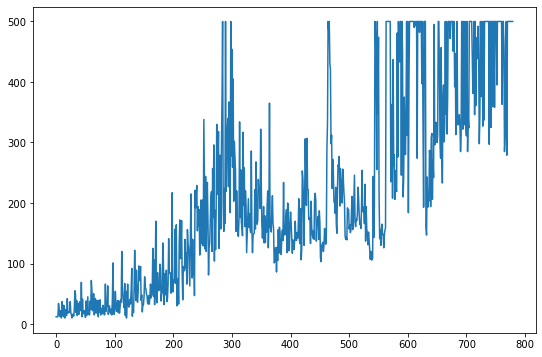

In [ ]:
agent.env = gym.make('CartPole-v1')
agent.env.seed(0)

try:
  nature.evolve(exploration_profile,verbose=True,render_every=100,fps=50)
except KeyboardInterrupt:
  print('\n\nTraining interrupted\n\n')
agent.env.close()

plt.figure(figsize=(9,6))
plt.plot(nature.score_log)

Text(0, 0.5, 'T profile')

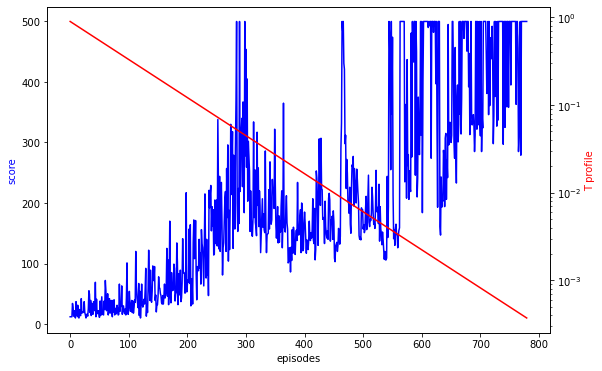

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(nature.score_log, color='blue')
# ax.plot(nature.cumulated_reward_log, color='cyan')
ax.set_ylabel('score', color='blue')
ax.set_xlabel('episodes')

ax2 = ax.twinx()
ax2.semilogy(exploration_profile.profile[:len(nature.score_log)], color='red')
ax2.set_ylabel('T profile', color='red')

In [ ]:
# states, qvalues =  agent.run_episode(fps=50,render=True, debug=True)
agent.env.close()

In [ ]:
qvalues

In [ ]:
agent.env = EnvWrapper(gym.make('CartPole-v1'), './videos/vanilla2.mp4')
agent.run_episode(fps=50, render=True)
agent.env.close()

final score: 500


### Improvements

#### Modifying the reward

In [ ]:
class Evolver_cc(Evolver):
  '''
  Modifies the reward adding to it

  'posiion_weight'*|position|**'position_exponent' + 'angle_weight'*|angle|**'angle_exponent'
  
  When the game terminates because the gym env returned done = True, an additional 'end_state_penalty' is added to the reward
  '''
  def __init__(self, *args, position_weight=0, position_exponent=1, angle_weight=0, angle_exponent=1, end_state_penalty=0, **kwargs):
    super().__init__(*args, **kwargs)

    self.pos_w = position_weight
    self.pos_exp = position_exponent
    self.ang_w = angle_weight
    self.ang_exp = angle_exponent
    self.end_state_penalty = end_state_penalty

  def modify_reward(self, agent):
    agent.score += 1
    agent.reward += self.pos_w*np.abs(agent.aux_state[0])**self.pos_exp + self.ang_w*np.abs(agent.aux_state[2])**self.ang_exp

    if agent.next_state is None:
      agent.reward += self.end_state_penalty

##### Keep the cart in the center

In [ ]:
net_params = {'Ni': state_space_dim, 'Nhs': [128, 128], 'No': action_space_dim, 'activation_function': nn.Tanh}

policy_net = FCN(**net_params)
target_net = FCN(**net_params)

agent = Agent(None,policy_net,policy=softmax_policy) # for now set the env to None

evolver_params = {'agent': agent, 'target_net': target_net, 'optimizer_type': optim.SGD, 'optimizer_params': {'lr': 1e-2},
                  'loss_function': nn.SmoothL1Loss(), 'batch_size': 128,
                  'position_weight': -0.5, 'position_exponent': 1, 'end_state_penalty': 0,
                  'update_target_net_every': 10}

nature = Evolver_cc(**evolver_params)

FCN initialized
Shape flow:  [4, 128, 128, 2]
FCN initialized
Shape flow:  [4, 128, 128, 2]


Episode 0: beta = 9.000e-01, final score: 14
Updating target net
Episode 1: beta = 8.910e-01, final score: 22
Episode 2: beta = 8.822e-01, final score: 16
Episode 3: beta = 8.734e-01, final score: 19
Episode 4: beta = 8.647e-01, final score: 21
Episode 5: beta = 8.561e-01, final score: 25
Episode 6: beta = 8.476e-01, final score: 39
Episode 7: beta = 8.392e-01, final score: 41
Episode 8: beta = 8.308e-01, final score: 26
Episode 9: beta = 8.225e-01, final score: 14
Episode 10: beta = 8.144e-01, final score: 13
Updating target net
Episode 11: beta = 8.063e-01, final score: 21
Episode 12: beta = 7.982e-01, final score: 11
Episode 13: beta = 7.903e-01, final score: 14
Episode 14: beta = 7.824e-01, final score: 16
Episode 15: beta = 7.746e-01, final score: 23
Episode 16: beta = 7.669e-01, final score: 14
Episode 17: beta = 7.593e-01, final score: 20
Episode 18: beta = 7.517e-01, final score: 13
Episode 19: beta = 7.443e-01, final score: 13
Episode 20: beta = 7.369e-01, final score: 25
Upda

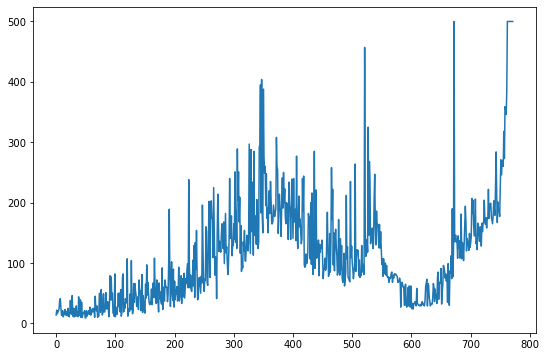

In [ ]:
agent.env = gym.make('CartPole-v1')
agent.env.seed(0)

try:
  nature.evolve(exploration_profile,verbose=True,render_every=100,fps=50)
except KeyboardInterrupt:
  print('\n\nTraining interrupted\n\n')
agent.env.close()

plt.figure(figsize=(9,6))
plt.plot(nature.score_log)

Text(0, 0.5, 'T profile')

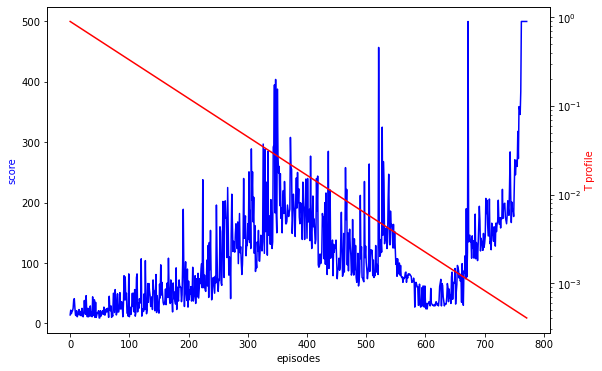

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(nature.score_log, color='blue')
# ax.plot(nature.cumulated_reward_log, color='cyan')
ax.set_ylabel('score', color='blue')
ax.set_xlabel('episodes')

ax2 = ax.twinx()
ax2.semilogy(exploration_profile.profile[:len(nature.score_log)], color='red')
ax2.set_ylabel('T profile', color='red')

In [ ]:
agent.env = EnvWrapper(gym.make('CartPole-v1'), './videos/mod_r_c.mp4')
agent.run_episode(fps=50,render=True)
agent.env.close()

final score: 500


In [ ]:
agent.env.close()

##### Keeping the pole vertical

In [ ]:
net_params = {'Ni': state_space_dim, 'Nhs': [128, 128], 'No': action_space_dim, 'activation_function': nn.Tanh}

policy_net = FCN(**net_params)
target_net = FCN(**net_params)

agent = Agent(None,policy_net,policy=softmax_policy) # for now set the env to None

evolver_params = {'agent': agent, 'target_net': target_net, 'optimizer_type': optim.SGD, 'optimizer_params': {'lr': 1e-2},
                  'loss_function': nn.SmoothL1Loss(), 'batch_size': 128,
                  'position_weight': -0.2, 'position_exponent': 4, 'end_state_penalty': 0, 'angle_weight': -5, 'angle_exponent': 4,
                  'update_target_net_every': 10}

nature = Evolver_cc(**evolver_params)

FCN initialized
Shape flow:  [4, 128, 128, 2]
FCN initialized
Shape flow:  [4, 128, 128, 2]


Episode 0: beta = 9.000e-01, final score: 15
Updating target net
Episode 1: beta = 8.910e-01, final score: 16
Episode 2: beta = 8.822e-01, final score: 21
Episode 3: beta = 8.734e-01, final score: 28
Episode 4: beta = 8.647e-01, final score: 15
Episode 5: beta = 8.561e-01, final score: 11
Episode 6: beta = 8.476e-01, final score: 58
Episode 7: beta = 8.392e-01, final score: 15
Episode 8: beta = 8.308e-01, final score: 20
Episode 9: beta = 8.225e-01, final score: 10
Episode 10: beta = 8.144e-01, final score: 20
Updating target net
Episode 11: beta = 8.063e-01, final score: 17
Episode 12: beta = 7.982e-01, final score: 13
Episode 13: beta = 7.903e-01, final score: 12
Episode 14: beta = 7.824e-01, final score: 12
Episode 15: beta = 7.746e-01, final score: 13
Episode 16: beta = 7.669e-01, final score: 28
Episode 17: beta = 7.593e-01, final score: 28
Episode 18: beta = 7.517e-01, final score: 28
Episode 19: beta = 7.443e-01, final score: 13
Episode 20: beta = 7.369e-01, final score: 22
Upda

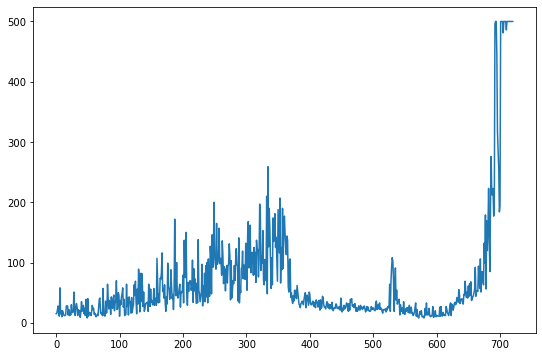

In [ ]:
agent.env = gym.make('CartPole-v1')
agent.env.seed(0)

try:
  nature.evolve(exploration_profile,verbose=True,render_every=100,fps=50)
except KeyboardInterrupt:
  print('\n\nTraining interrupted\n\n')
agent.env.close()

plt.figure(figsize=(9,6))
plt.plot(nature.score_log)

Text(0, 0.5, 'T profile')

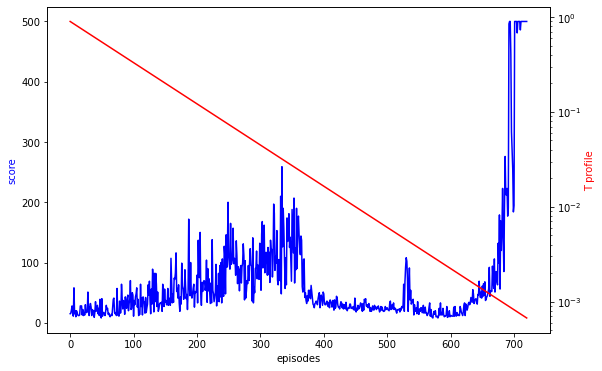

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(nature.score_log, color='blue')
# ax.plot(nature.cumulated_reward_log, color='cyan')
ax.set_ylabel('score', color='blue')
ax.set_xlabel('episodes')

ax2 = ax.twinx()
ax2.semilogy(exploration_profile.profile[:len(nature.score_log)], color='red')
ax2.set_ylabel('T profile', color='red')

In [ ]:
agent.env = EnvWrapper(gym.make('CartPole-v1'), './videos/mod_r_cv.mp4')
agent.run_episode(fps=50,render=True)
agent.env.close()

final score: 500


#### Automatically choosing when to update the target net

Spoiler: this idea didn't work

In [ ]:
class Evolver_best_tn(Evolver_cc):
  '''
  The target net is updated with probability exp((score - best score so far)/'csi') and at most every 'update_target_net_every' episodes
  '''

  def __init__(self, *args, csi=0, **kwargs):
    super().__init__(*args, **kwargs)

    self.csi = csi
    self.best_score = 0
    self.last_update = 0

  def update_target_net(self, verbose=False):
    update = False
    if self.agent.score > self.best_score:
      self.best_score = self.agent.score
      update = True

    elif self.csi > 0:
      if random.random() < np.exp((self.agent.score - self.best_score)/self.csi):
        update = True
      elif self.episode_num - self.last_update > self.update_target_net_every:
        update = True

    if update:
      self.last_update = self.episode_num
      if verbose:
        print('Updating target net')
      self.target_net.load_state_dict(self.agent.policy_net.state_dict())

In [ ]:
net_params = {'Ni': state_space_dim, 'Nhs': [128, 128], 'No': action_space_dim, 'activation_function': nn.Tanh}

policy_net = FCN(**net_params)
target_net = FCN(**net_params)

agent = Agent(None,policy_net,policy=softmax_policy) # for now set the env to None

evolver_params = {'agent': agent, 'target_net': target_net, 'optimizer_type': optim.SGD, 'optimizer_params': {'lr': 1e-3},
                  'loss_function': nn.SmoothL1Loss(), 'batch_size': 128,
                  'position_weight': -0.2, 'position_exponent': 1, 'end_state_penalty': 0, 'angle_weight': -0.5, 'angle_exponent': 2,
                  'update_target_net_every': 50, 'csi': 5}

nature = Evolver_best_tn(**evolver_params)

FCN initialized
Shape flow:  [4, 128, 128, 2]
FCN initialized
Shape flow:  [4, 128, 128, 2]


Episode 0: final score: 9
Updating target net
Episode 1: final score: 33
Updating target net
Episode 2: final score: 39
Updating target net
Episode 3: final score: 15
Updating target net
Episode 4: final score: 21
Updating target net
Episode 5: final score: 15
Updating target net
Episode 6: final score: 15
Updating target net
Episode 7: final score: 11
Updating target net
Episode 8: final score: 12
Updating target net
Episode 9: final score: 16
Updating target net
Episode 10: final score: 12
Updating target net
Episode 11: final score: 9
Episode 12: final score: 16
Updating target net
Episode 13: final score: 23
Updating target net
Episode 14: final score: 14
Episode 15: final score: 12
Updating target net
Episode 16: final score: 9
Episode 17: final score: 11
Episode 18: final score: 16
Updating target net
Episode 19: final score: 9
Episode 20: final score: 25
Updating target net
Episode 21: final score: 17
Updating target net
Episode 22: final score: 14
Updating target net
Episode 23

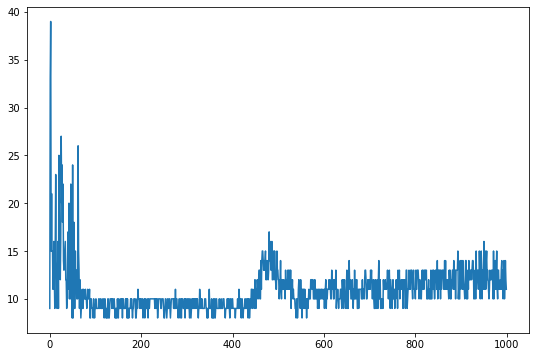

In [ ]:
agent.env = gym.make('CartPole-v1')
agent.env.seed(0)

try:
  nature.evolve(exploration_profile,verbose=True,render_every=100,fps=50)
except KeyboardInterrupt:
  print('\n\nTraining interrupted\n\n')
agent.env.close()

plt.figure(figsize=(9,6))
plt.plot(nature.score_log)

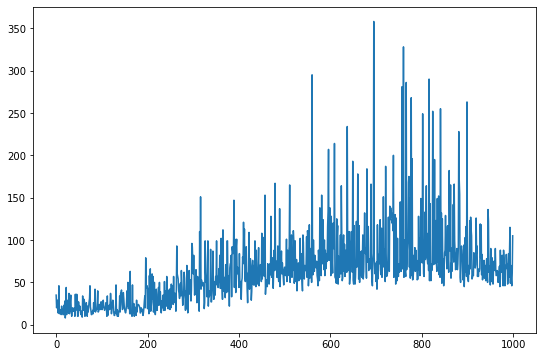

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(nature.score_log)

This doesn't seem to produce interesting good results

#### Wavy exploration profile

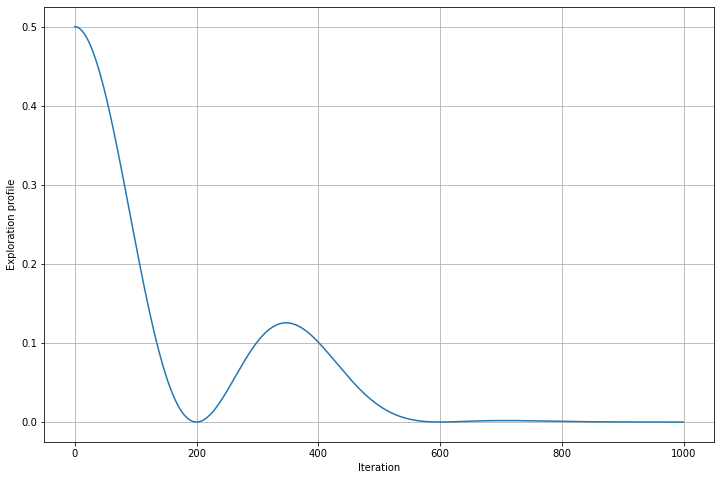

In [ ]:
initial_value = 0.5
lam = 0.01
num_iterations = 1000
oscillation_period = 400
exp_decay = np.exp(-lam/num_iterations) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile_w = ExplorationProfile([initial_value * (exp_decay ** (i**2))*np.cos(np.pi*i/oscillation_period)**2 for i in range(num_iterations)])

exploration_profile_w.plot()

In [ ]:
net_params = {'Ni': state_space_dim, 'Nhs': [128, 128], 'No': action_space_dim, 'activation_function': nn.Tanh}

policy_net = FCN(**net_params)
target_net = FCN(**net_params)

agent = Agent(None,policy_net,policy=softmax_policy) # for now set the env to None

evolver_params = {'agent': agent, 'target_net': target_net, 'optimizer_type': optim.SGD, 'optimizer_params': {'lr': 3e-2},
                  'loss_function': nn.SmoothL1Loss(), 'batch_size': 128,
                  'position_weight': -0.2, 'position_exponent': 1, 'end_state_penalty': 0, 'angle_weight': -0.5, 'angle_exponent': 2,
                  'update_target_net_every': 10}

nature = Evolver_cc(**evolver_params)

FCN initialized
Shape flow:  [4, 128, 128, 2]
FCN initialized
Shape flow:  [4, 128, 128, 2]


Episode 0: beta = 5.000e-01, final score: 13
Updating target net
Episode 1: beta = 5.000e-01, final score: 25
Episode 2: beta = 4.999e-01, final score: 49
Episode 3: beta = 4.997e-01, final score: 13
Episode 4: beta = 4.994e-01, final score: 24
Episode 5: beta = 4.991e-01, final score: 42
Episode 6: beta = 4.987e-01, final score: 17
Episode 7: beta = 4.982e-01, final score: 10
Episode 8: beta = 4.977e-01, final score: 23
Episode 9: beta = 4.971e-01, final score: 21
Episode 10: beta = 4.964e-01, final score: 40
Updating target net
Episode 11: beta = 4.957e-01, final score: 14
Episode 12: beta = 4.949e-01, final score: 15
Episode 13: beta = 4.940e-01, final score: 34
Episode 14: beta = 4.930e-01, final score: 19
Episode 15: beta = 4.920e-01, final score: 80
Episode 16: beta = 4.909e-01, final score: 15
Episode 17: beta = 4.897e-01, final score: 34
Episode 18: beta = 4.885e-01, final score: 28
Episode 19: beta = 4.872e-01, final score: 31
Episode 20: beta = 4.858e-01, final score: 24
Upda

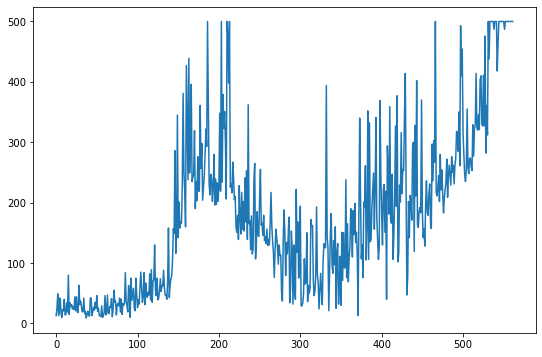

In [ ]:
agent.env = gym.make('CartPole-v1')
agent.env.seed(0)

try:
  nature.evolve(exploration_profile_w,verbose=True,render_every=100,fps=50)
except KeyboardInterrupt:
  print('\n\nTraining interrupted\n\n')
agent.env.close()

plt.figure(figsize=(9,6))
plt.plot(nature.score_log)

Text(0, 0.5, 'T profile')

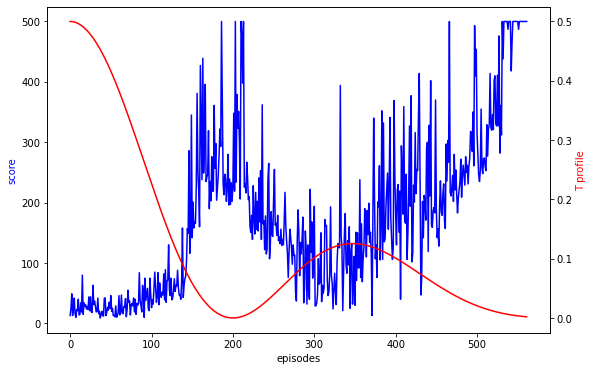

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(nature.score_log, color='blue')
# ax.plot(nature.cumulated_reward_log, color='cyan')
ax.set_ylabel('score', color='blue')
ax.set_xlabel('episodes')

ax2 = ax.twinx()
ax2.plot(exploration_profile_w.profile[:len(nature.score_log)], color='red')
ax2.set_ylabel('T profile', color='red')

#### Feedback on the exploration profile

In [ ]:
class ExplorationProfileFeedback(ExplorationProfile):
  '''
  beta = 'start_value'*exp(('bias' - S)/'csi') where S is the average angent's score in the last 'mean_size' episodes
  '''

  def __init__(self, max_iterations=1000, start_value=1, csi=20, bias=0, mean_size=10):
    self.max_iterations = max_iterations
    self.profile = [start_value]
    self.csi = csi
    self.bias = bias
    self.mean_size = mean_size

  def __len__(self):
    return self.max_iterations

  def update(self, evolver):
    if len(self.profile) < self.max_iterations:
      self.profile.append(self.profile[0]*np.exp((self.bias - np.mean(evolver.score_log[-self.mean_size:]))/self.csi))
      if self.profile[-1] < 1e-9:
        self.profile[-1] = 0

In [ ]:
exploration_profile_f = ExplorationProfileFeedback(csi=80, mean_size=100, bias=0, start_value=0.1)

net_params = {'Ni': state_space_dim, 'Nhs': [128, 128], 'No': action_space_dim, 'activation_function': nn.Tanh}

policy_net = FCN(**net_params)
target_net = FCN(**net_params)

agent = Agent(None,policy_net,policy=epsilon_greedy_policy) # for now set the env to None

evolver_params = {'agent': agent, 'target_net': target_net, 'optimizer_type': optim.SGD, 'optimizer_params': {'lr': 3e-2},
                  'loss_function': nn.SmoothL1Loss(), 'batch_size': 128, 'discount_rate': 0.9,
                  'position_weight': -0.2, 'position_exponent': 1, 'end_state_penalty': 0, 'angle_weight': -0.5, 'angle_exponent': 2,
                  'update_target_net_every': 10}

nature = Evolver_cc(**evolver_params)

FCN initialized
Shape flow:  [4, 128, 128, 2]
FCN initialized
Shape flow:  [4, 128, 128, 2]


Episode 0: beta = 1.000e-01, final score: 28
Updating target net
Episode 1: beta = 7.047e-02, final score: 36
Episode 2: beta = 6.703e-02, final score: 74
Episode 3: beta = 5.627e-02, final score: 22
Episode 4: beta = 6.065e-02, final score: 42
Episode 5: beta = 6.035e-02, final score: 34
Episode 6: beta = 6.116e-02, final score: 21
Episode 7: beta = 6.320e-02, final score: 48
Episode 8: beta = 6.209e-02, final score: 29
Episode 9: beta = 6.288e-02, final score: 36
Episode 10: beta = 6.297e-02, final score: 44
Updating target net
Episode 11: beta = 6.247e-02, final score: 23
Episode 12: beta = 6.343e-02, final score: 38
Episode 13: beta = 6.334e-02, final score: 41
Episode 14: beta = 6.308e-02, final score: 21
Episode 15: beta = 6.392e-02, final score: 47
Episode 16: beta = 6.337e-02, final score: 24
Episode 17: beta = 6.395e-02, final score: 36
Episode 18: beta = 6.394e-02, final score: 28
Episode 19: beta = 6.427e-02, final score: 23
Episode 20: beta = 6.477e-02, final score: 96
Upda

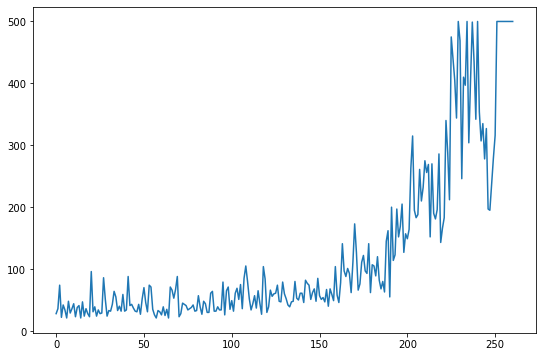

In [ ]:
agent.env = gym.make('CartPole-v1')
agent.env.seed(0)

try:
  nature.evolve(exploration_profile_f,verbose=True,render_every=100,fps=50)
except KeyboardInterrupt:
  print('\n\nTraining interrupted\n\n')
agent.env.close()

plt.figure(figsize=(9,6))
plt.plot(nature.score_log)

Text(0, 0.5, 'T profile')

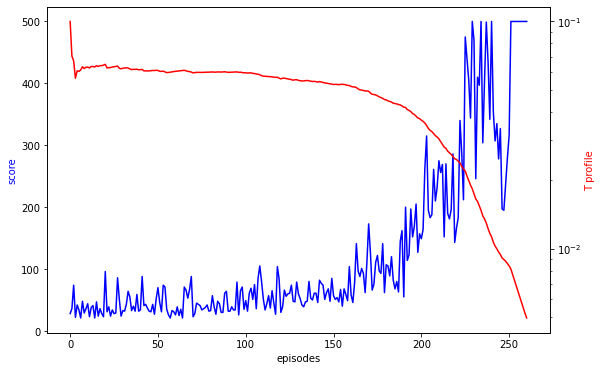

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(nature.score_log, color='blue')
# ax.plot(nature.cumulated_reward_log, color='cyan')
ax.set_ylabel('score', color='blue')
ax.set_xlabel('episodes')

ax2 = ax.twinx()
ax2.semilogy(exploration_profile_f.profile[:len(nature.score_log)], color='red')
ax2.set_ylabel('T profile', color='red')

In [ ]:
states, qvalues =  agent.run_episode(fps=50,render=True, debug=True, beta=0e-3)
agent.env.close()

final score: 317


In [ ]:
qvalues

This seems to be the most promising strategy

### Optuna hyperparameters search

In [ ]:
import optuna
global df
df = None

In [ ]:
name = 'optuna_search/study2/study'

if os.path.exists(f'{name}.csv'):
  df = pd.read_csv(f'{name}.csv')
  print('Loading existing study')


optimizer_type = optim.SGD

loss_function = nn.SmoothL1Loss()

net_type = FCN

evolver_type = Evolver_cc

max_iterations = 1000

max_score = 500
min_perfect_episodes = 10

verbose = False

def objective(trial):

  global df

  # sample hypermarameters
  
  # linear layers 
  n_l_layers = trial.suggest_int('nll', 2, 3)

  Nhs = []

  for j in range(n_l_layers):
    Nhs.append(trial.suggest_int(f'Nh{j+1}', 16, 256, log=True))


  # net params
  net_params = {'Ni': state_space_dim, 'Nhs': Nhs, 'No': action_space_dim, 'activation_function': nn.Tanh}
  print(net_params)

  # policy
  policy = trial.suggest_categorical('policy', ['epsilon_greedy', 'softmax'])
  print(policy)

  if policy == 'epsilon_greedy':
    policy = epsilon_greedy_policy
  else:
    policy = softmax_policy

  policy_net = net_type(**net_params)
  target_net = net_type(**net_params)

  # agent
  agent = Agent(None,policy_net,policy=policy)

  
  # optimizer part
  lr = trial.suggest_float('lr', 1e-4, 1, log=True)
  
  optimizer_params = {'lr': lr}
  print(optimizer_params)

  # train_batch_size
  train_batch_size = trial.suggest_int('train_batch_size', 64, 512, log=True)

  discount_rate = trial.suggest_float('discount_rate', 0.3, 1)

  # reward modifiers
  pos_w = trial.suggest_float('pos_w', -2, 0)
  pos_e = trial.suggest_int('pos_e', 1, 3)

  ang_w = trial.suggest_float('ang_w', -8, 0)
  ang_e = trial.suggest_int('ang_e', 1, 3)

  # end_state_pen = trial.suggest_float('end_state_penalty', -3, 0)
  end_state_pen = 0

  update_target_net_every = trial.suggest_int('update_target_net_every', 3, 20)

  # evolver
  evolver_fixed_params = {'agent': agent, 'target_net': target_net, 'optimizer_type': optimizer_type, 'optimizer_params': optimizer_params,
                          'loss_function': loss_function, 'max_score': max_score}

  evolver_params = {'batch_size': train_batch_size, 'discount_rate': discount_rate,
                    'position_weight': pos_w, 'position_exponent': pos_e, 'angle_weight': ang_w, 'angle_exponent': ang_e, 'end_state_penalty': end_state_pen,
                    'update_target_net_every': update_target_net_every}

  print(evolver_params)
  
  evolver = evolver_type(**evolver_fixed_params, **evolver_params)

  # exploration profile

  start_value = trial.suggest_float('beta0', 0.01, 1, log=True)
  csi = trial.suggest_float('csi', 10, 100, log=True)
  mean_size = trial.suggest_int('mean_size', 5, 200, log=True)

  exp_prof = ExplorationProfileFeedback(max_iterations=max_iterations,start_value=start_value, csi=csi, mean_size=mean_size)


  # running
  start_time = time.time()
  agent.env = gym.make('CartPole-v1')
  agent.env.seed(0)

  try:
    evolver.evolve(exp_prof, min_perfect_episodes=min_perfect_episodes,verbose=verbose,render_every=100,fps=50)
  except KeyboardInterrupt:
    print('\n\nTraining interrupted\n\n')
    o = input('Interrupt study? [y/n] ')
    if o == 'y':
      agent.env.close()
      raise KeyboardInterrupt

  agent.env.close()

  fig, ax = plt.subplots(figsize=(9,6))
  ax.plot(evolver.score_log, color='blue')
  ax.set_ylabel('score', color='blue')
  ax.set_xlabel('episodes')

  ax2 = ax.twinx()
  ax2.semilogy(exp_prof.profile[:len(evolver)], color='red')
  if policy == softmax_policy:
    ax2.set_ylabel('T profile', color='red')
  else:
    ax2.set_ylabel('epsilon profile', color='red')
  
  train_time = (time.time() - start_time)/60 # train time in minutes

  num_episodes = len(evolver)

  final_score = np.mean(evolver.score_log[-min_perfect_episodes:])

  print(f'{num_episodes = }, {final_score = }, {train_time = } min')

  # dictionary with all the hyperparameters and performance of the net
  hyper_dict = dict(**net_params, **optimizer_params, **evolver_params,
                    **{'num_episodes': num_episodes, 'final_score': final_score, 'train_time': train_time})

  if df is None:
    df = pd.DataFrame([], columns=list(hyper_dict.keys()))

  # save results
  fol = name.rsplit('/',1)[0]

  torch.save(agent.policy_net.state_dict(), f'{fol}/trial{len(df)}_net.pth')
  np.save(f'{fol}/trial{len(df)}_score_log.npy',np.array(evolver.score_log))
  np.save(f'{fol}/trial{len(df)}_beta_log.npy', np.array(exp_prof.profile[:len(evolver)]))

  df.loc[len(df)] = hyper_dict

  df.to_csv(f'{name}.csv', index=False)

  return num_episodes + max_score - final_score


study = optuna.create_study(study_name=name, storage=f'sqlite:///{name}.db', load_if_exists=True)

[I 2021-02-05 22:37:48,017] Using an existing study with name 'optuna_search/study2/study' instead of creating a new one.


In [ ]:
study.optimize(objective, n_trials=50)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

#### Load the best agent

In [ ]:
def load(folder, trial, load_study=True):
  study = None
  if load_study:
    name = folder + '/study'
    study = optuna.create_study(study_name=name, storage=f'sqlite:///{name}.db', load_if_exists=True)

  policy_net_state_dict = torch.load(f'{folder}/trial{trial}_net.pth')

  score_log = np.load(f'{folder}/trial{trial}_score_log.npy')
  beta_log = np.load(f'{folder}/trial{trial}_beta_log.npy')

  return study, policy_net_state_dict, score_log, beta_log
  

FCN initialized
Shape flow:  [4, 69, 219, 2]


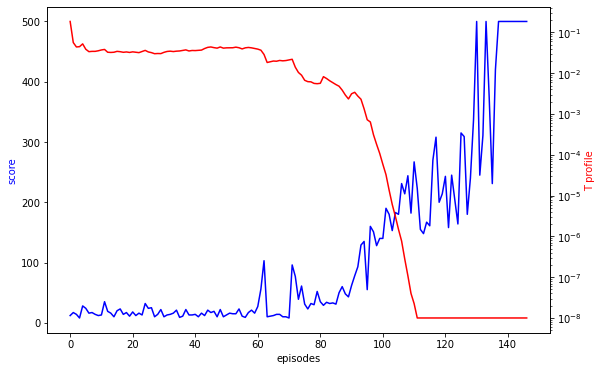

In [ ]:
study, policy_net_state_dict, score_log, beta_log = load('optuna_search/study2', 32, load_study=True)

for i,beta in enumerate(beta_log):
  if beta < 1e-8:
    beta_log[i] = 1e-8

fig, ax = plt.subplots(figsize=(9,6))
ax.plot(score_log, color='blue')
ax.set_ylabel('score', color='blue')
ax.set_xlabel('episodes')

ax2 = ax.twinx()
ax2.semilogy(beta_log, color='red')
ax2.set_ylabel('T profile', color='red')


### Create and load the best agent

net_params = {'Ni': state_space_dim, 'No': action_space_dim, 'activation_function': nn.Tanh, 'Nhs': [69, 219]}

policy_net = FCN(**net_params)
policy_net.load_state_dict(policy_net_state_dict)

agent = Agent(None, policy_net, policy=softmax_policy)

In [ ]:
study.study_name

'optuna_search/study2/study'

In [ ]:
print(study.best_trial)
study.best_params

FrozenTrial(number=32, value=147.0, datetime_start=datetime.datetime(2021, 2, 6, 0, 11, 9, 872016), datetime_complete=datetime.datetime(2021, 2, 6, 0, 11, 58, 788037), params={'Nh1': 69, 'Nh2': 219, 'ang_e': 1, 'ang_w': -7.059352294948454, 'beta0': 0.18569355184556005, 'csi': 10.074121483436395, 'discount_rate': 0.9148842463274104, 'lr': 0.1632476038376296, 'mean_size': 18, 'nll': 2, 'policy': 'softmax', 'pos_e': 2, 'pos_w': -1.415586740965399, 'train_batch_size': 181, 'update_target_net_every': 10}, distributions={'Nh1': IntLogUniformDistribution(high=256, low=16, step=1), 'Nh2': IntLogUniformDistribution(high=256, low=16, step=1), 'ang_e': IntUniformDistribution(high=3, low=1, step=1), 'ang_w': UniformDistribution(high=0, low=-8), 'beta0': LogUniformDistribution(high=1, low=0.01), 'csi': LogUniformDistribution(high=100, low=10), 'discount_rate': UniformDistribution(high=1, low=0.3), 'lr': LogUniformDistribution(high=1, low=0.0001), 'mean_size': IntLogUniformDistribution(high=200, low

{'Nh1': 69,
 'Nh2': 219,
 'ang_e': 1,
 'ang_w': -7.059352294948454,
 'beta0': 0.18569355184556005,
 'csi': 10.074121483436395,
 'discount_rate': 0.9148842463274104,
 'lr': 0.1632476038376296,
 'mean_size': 18,
 'nll': 2,
 'policy': 'softmax',
 'pos_e': 2,
 'pos_w': -1.415586740965399,
 'train_batch_size': 181,
 'update_target_net_every': 10}

In [ ]:
agent.env = gym.make('CartPole-v1')

scores = []
for i in tqdm(range(100)):
  agent.run_episode(render=True,fps=None)
  scores.append(agent.score)
agent.env.close()

final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 273
final score: 500
final score: 500
final score: 500
final score: 302
final score: 500
final score: 500
final score: 341
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 309
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 5

In [ ]:
n_perfect = 0
combo = 5
max_combo = 0
for score in scores:
  if score == 500:
    combo += 1
    n_perfect += 1
    if combo > max_combo:
      max_combo = combo
  else:
    combo = 0
    print(score)

print('\n\n', n_perfect, max_combo, np.mean(scores))

273
302
341
309
395


 95 37 491.2


In [ ]:
agent.env = EnvWrapper(gym.make('CartPole-v1'), './videos/best.mp4')
agent.run_episode(fps=50, render=True)
agent.env.close()

final score: 500


### Evaluate score

In [ ]:
def evaluate_score(score_log, max_combo=10, min_score_for_combo=500):
  first_combos = np.ones(max_combo)*(-1)

  combo = 0
  for i,score in enumerate(score_log):
    if score >= min_score_for_combo:
      combo += 1
      if first_combos[combo - 1] == -1:
        first_combos[combo - 1] = i
    else:
      combo = 0

  return first_combos

In [ ]:
evaluate_score(nature.score_log)

## Cart-Pole with pixels

In [ ]:
from torchvision import transforms

os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # solving a bug of colab.

In [ ]:
use_gpu = True

# Check if the GPU is available
device = torch.device("cuda") if (torch.cuda.is_available() and use_gpu) else torch.device("cpu")
if use_gpu:
  print(f"Training device: {device}: {torch.cuda.get_device_name(0)}")
else:
  print(f'Training device: {device}')

Training device: cuda: GeForce GTX 960M


### Preprocessing the screen pixels

In [ ]:
class Cut():
  '''
  Crop an image in the x, y and color dimensions.

  Args:
    x_cut
    y_cut
    c_cut:
      every one of them needs to be None or a tuple (min, max), where min is inclusive and max exclusive
  '''

  def __init__(self, x_cut=None, y_cut=None, c_cut=None):
    self.x_cut = x_cut
    self.y_cut = y_cut
    self.c_cut = c_cut

  def __call__(self, pic):
    if self.x_cut is None:
      self.x_cut = (0, pic.shape[1])
    if self.y_cut is None:
      self.y_cut = (0, pic.shape[0])
    if self.c_cut is None:
      self.c_cut = (0, pic.shape[2])

    return pic[self.y_cut[0]:self.y_cut[1], self.x_cut[0]:self.x_cut[1], self.c_cut[0]:self.c_cut[1]]

class Downsample():
  '''
  Downsamples an image in the x and y dimensions.

  Args:
    downsample_x
    downsample_y:
      both int (default 1)
  '''

  def __init__(self, downsample_x=1, downsample_y=1):
    self.downsample_x = downsample_x
    self.downsample_y = downsample_y

  def __call__(self, pic):
    return pic[::self.downsample_y, ::self.downsample_x, :]



class ScreenPreprocesser():
  '''
  Preprocesses the images

  Args:
    transform: transformation to be aplied to the images
    device: device on which to create the final tensor
    negative: bool (default False)
      whether to make the negative of the images
  '''

  def __init__(self, transform=None, device=None, negative=False):
    self.transform = transform
    self.device = device
    self.negative = negative

  def __call__(self, pic):
    if self.transform is not None:
      pic = self.transform(pic)
    
    pic = torch.tensor(pic/255, dtype=torch.float32, device=self.device, requires_grad=False).permute([2,0,1])
    if self.negative:
      pic = 1 - pic
    return pic

In [ ]:
env.reset()
env.step(0)
opic = env.render(mode='rgb_array')
env.close()

In [ ]:
transform = transforms.Compose([
                               Cut(y_cut=(160,320), c_cut=(2,3), x_cut=(100, 500)),
                               Downsample(downsample_x=1, downsample_y=6)
])

screen_prep = ScreenPreprocesser(transform, device=device, negative=True)

print(opic.shape)
pic = screen_prep(opic)

input_shape = tuple(pic.shape)
print(input_shape)

(400, 600, 3)
(1, 27, 400)


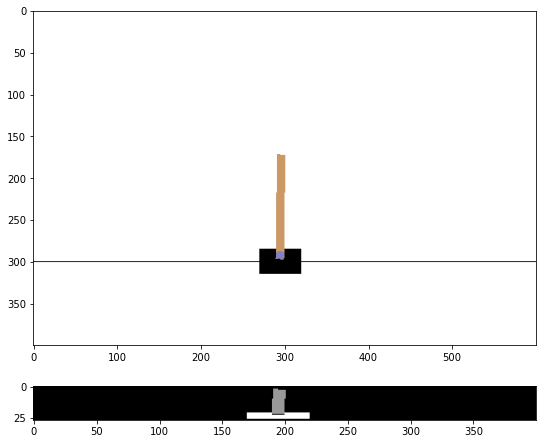

In [ ]:
import matplotlib.gridspec as gridspec

fig=plt.figure(figsize=(9,8))
gs = gridspec.GridSpec(5,1)
ax1 = fig.add_subplot(gs[:4,:])
ax2 = fig.add_subplot(gs[4:,:])

ax1.imshow(opic)
ax2.imshow(pic.squeeze().cpu().numpy(), cmap='gist_gray')

### Evolver for pixels

In [ ]:
class Evolver_cc_pixels(Evolver_cc):
  '''
  Class inheriting from Evolver to deal with the training using pixels.

  Args:
    consecutive frames: int (default 1)
      number of consecutive frames to be provided as input to the agent's policy net
    push_to_mem_every: int (default 1)
      number of steps every which to push a new sample to the replay memory
    max_score_for_pushing: float (default -np.infty)
      If the final score of the previous episode was above max_score_for_pushing, during the current episode no new samples are pushed to the replay memory

  *args, **kwargs: arguments of the parent class
  '''

  def __init__(self, *args, consecutive_frames=1, push_to_mem_every=1, max_score_for_pushing=np.infty, **kwargs):
    super().__init__(*args, **kwargs)

    self.consecutive_frames = deque(maxlen=consecutive_frames)
    self.push_to_mem_every = push_to_mem_every
    self.max_score_for_pushing = max_score_for_pushing

  def modify_reward(self, agent):
    agent.score += 1

    if agent.next_state is None:
      agent.reward += self.end_state_penalty
    else:
      agent.reward += self.pos_w*np.abs(agent.aux_next_state[0])**self.pos_exp + self.ang_w*np.abs(agent.aux_next_state[2])**self.ang_exp

  def modifier(self, agent):
    # modify the reward of the agent: e.g. add penalties
    self.modify_reward(agent)

    if agent.t == 0: # empty the deque at the beginning of every episode
      self.consecutive_frames.clear()

    if agent.next_state is not None:
      self.consecutive_frames.append(agent.next_state)
      agent.next_state = torch.cat(list(self.consecutive_frames))

    # add new samples to the replay memory
    if agent.is_ready and agent.t % self.push_to_mem_every == 0:
      if not (len(self.score_log) > 0 and self.score_log[-1] > self.max_score_for_pushing):
        self.replay_mem.push(agent.state, agent.action, agent.next_state, agent.reward)
    
    if len(self.replay_mem) == self.min_samples:
      print('\n\nInitiating learning\n\n')
    if len(self.replay_mem) > self.min_samples:
      # update policy net
      self.update_step()

class DefaultPixelModifier():

  def __init__(self, consecutive_frames=1):
    self.consecutive_frames = deque(maxlen=consecutive_frames)

  def __call__(self, agent):
    agent.score += 1

    if agent.t == 0: # empty the deque at the beginning of every episode
      self.consecutive_frames.clear()

    if agent.next_state is not None:
      self.consecutive_frames.append(agent.next_state)
      agent.next_state = torch.cat(list(self.consecutive_frames))

### Test

Here I manually tried different combination of hyperparameters and approaches

In [ ]:
consecutive_frames = 4

input_shape = (consecutive_frames, input_shape[1], input_shape[2])

net_params = {'channels': [16,32,16], 'kernel_sizes': [4,4,4], 'strides': [2,2,2], 'paddings': [0,0,0],
              'Nhs': [256], 'No': action_space_dim, 'input_shape': input_shape}

policy_net = CNN(**net_params)
target_net = CNN(**net_params)

agent = Agent(None,policy_net,policy=softmax_policy, screen_preprocesser=screen_prep, choose_action_every=1) # for now set the env to None

evolver_params = {'agent': agent, 'target_net': target_net, 'optimizer_type': optim.RMSprop, 'optimizer_params': {'lr': 3e-4},
                  'loss_function': nn.SmoothL1Loss(), 'batch_size': 32,
                  'position_weight': -1.4, 'position_exponent': 2, 'angle_weight': -7, 'angle_exponent': 1, 'end_state_penalty': -10,
                  'device': device, 'memory_capacity': 4000, 'update_target_net_every': 5}

nature = Evolver_cc_pixels(**evolver_params, consecutive_frames=consecutive_frames, max_score_for_pushing=350)

CNN initialized
Shape flow:  [(4, 27, 400), (16, 12, 199), (32, 5, 98), (16, 1, 48), 768, 256, 2]
CNN initialized
Shape flow:  [(4, 27, 400), (16, 12, 199), (32, 5, 98), (16, 1, 48), 768, 256, 2]


In [ ]:
exploration_profile = ExplorationProfileFeedback(max_iterations=500,start_value=0.18,csi=10,mean_size=18)
# exploration_profile = LinExplorationProfile(max_iterations=1000, start_value=0.5, end_value=0.0005, delta=300)

In [ ]:
exploration_profile.max_iterations = 600
exploration_profile.profile.append(1e-6)
agent.choose_action_every = 1
# nature.optimizer = optim.RMSprop(nature.agent.policy_net.parameters(), lr=1e-3)

Episode 0: beta = 1.800e-01, final score: 21
Updating target net
Episode 1: beta = 2.204e-02, final score: 17
Episode 2: beta = 2.692e-02, final score: 19
Episode 3: beta = 2.692e-02, final score: 9
Episode 4: beta = 3.457e-02, final score: 27
Episode 5: beta = 2.802e-02, final score: 11
Updating target net
Episode 6: beta = 3.181e-02, final score: 45
Episode 7: beta = 2.142e-02, final score: 14
Episode 8: beta = 2.346e-02, final score: 14
Episode 9: beta = 2.519e-02, final score: 19
Episode 10: beta = 2.535e-02, final score: 14
Updating target net
Episode 11: beta = 2.668e-02, final score: 21
Episode 12: beta = 2.626e-02, final score: 23
Episode 13: beta = 2.551e-02, final score: 13
Episode 14: beta = 2.673e-02, final score: 20
Episode 15: beta = 2.657e-02, final score: 16
Updating target net
Episode 16: beta = 2.709e-02, final score: 10
Episode 17: beta = 2.855e-02, final score: 18
Episode 18: beta = 2.862e-02, final score: 21
Episode 19: beta = 2.862e-02, final score: 18
Episode 20:

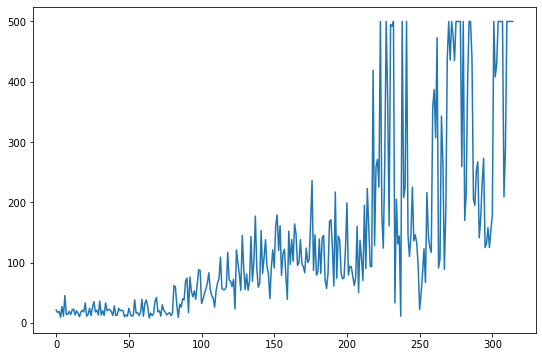

In [ ]:
agent.env = gym.make('CartPole-v1')
agent.env.seed(0)

try:
  nature.evolve(exploration_profile,verbose=True,render_every=100,fps=50, min_perfect_episodes=5)
except KeyboardInterrupt:
  print('\n\nTraining interrupted\n\n')
agent.env.close()

plt.figure(figsize=(9,6))
plt.plot(nature.score_log)

In [ ]:
agent.env.close()

Text(0, 0.5, 'T profile')

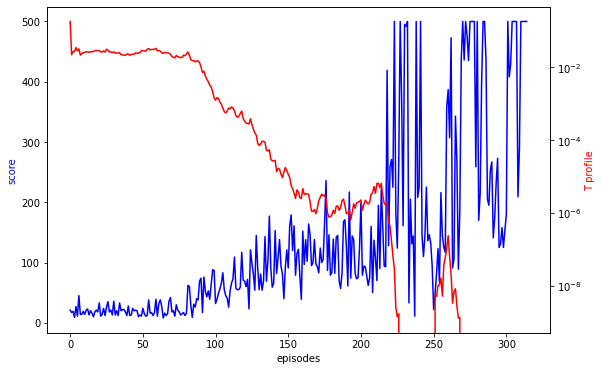

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(nature.score_log, color='blue')
# ax.plot(nature.cumulated_reward_log, color='cyan')
# ax.plot(np.convolve(nature.score_log, np.ones(10)/10), color='cyan')
ax.set_ylabel('score', color='blue')
ax.set_xlabel('episodes')

ax2 = ax.twinx()
ax2.semilogy(exploration_profile.profile[:len(nature.score_log)], color='red')
ax2.set_ylabel('T profile', color='red')

In [ ]:
evaluate_score(nature.score_log)

array([223., 276., 277., 278., 314.,  -1.,  -1.,  -1.,  -1.,  -1.])

In [ ]:
agent.choose_action_every = 1
agent.policy_net.to(device)

scores = []
for i in range(100):
  agent.run_episode(beta=0.0, render=True, fps=50, debug=False, modifier=DefaultPixelModifier(4))
  scores.append(agent.score)
agent.env.close()

final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 162
final score: 500
final score: 500
final score: 500
final score: 500
final score: 176
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 40
final score: 500
final score: 500
final score: 500
final score: 12
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500
final score: 500

In [ ]:
n_perfect = 0
combo = 5
max_combo = 0
for score in scores:
  if score == 500:
    combo += 1
    n_perfect += 1
    if combo > max_combo:
      max_combo = combo
  else:
    combo = 0
    print(score)

print('\n\n', n_perfect, max_combo, np.mean(scores))

162
176
40
12
348
264


 94 39 480.02


In [ ]:
torch.save(agent.policy_net.state_dict(), 'pino2.pth')

In [ ]:
agent.policy_net.load_state_dict(torch.load('pino2.pth'))
agent.policy_net.to(device)

CNN(
  (conv_layers): Sequential(
    (conv1): Conv2d(4, 16, kernel_size=(4, 4), stride=(2, 2))
    (conv_act1): ReLU()
    (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
    (conv_act2): ReLU()
    (conv3): Conv2d(32, 16, kernel_size=(4, 4), stride=(2, 2))
    (conv_act3): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin_layers): Sequential(
    (lin1): Linear(in_features=768, out_features=256, bias=True)
    (lin_act1): ReLU()
  )
  (out): Linear(in_features=256, out_features=2, bias=True)
  (o_act): Identity()
)

In [ ]:
agent.env = EnvWrapper(gym.make('CartPole-v1'), './videos/pino2.mp4')
agent.run_episode(fps=50,render=True, modifier=DefaultPixelModifier(4))
agent.env.close()

final score: 500


#### Checking gpu memory

In [ ]:
len(nature.replay_mem)

0

In [ ]:
nature.replay_mem.memory.clear()

In [ ]:
agent.policy_net.cpu()
nature.target_net.cpu()

# for a in nature.replay_mem.memory:
#   for aa in a:
#     try:
#       del aa
#     except:
#       pass

torch.cuda.empty_cache()
torch.cuda.memory_allocated(0)

89412608

In [ ]:
torch.cuda.memory_reserved(0)

29360128

In [ ]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

In [ ]:
dump_tensors()

## Acrobot

In [ ]:
### Create environment
env = gym.make('Acrobot-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

env.close()

def default_modifier_acrobot(agent):
  agent.score -= 1

STATE SPACE SIZE: 6
ACTION SPACE SIZE: 3


In [ ]:
env.reset()

array([ 0.99603073, -0.08901003,  0.99567135,  0.09294385,  0.02653819,
       -0.04199653])

#### Random agent

In [ ]:
policy_net = FCN(Ni=state_space_dim,No=action_space_dim,)
agent = Agent(env,policy_net,policy=random_policy)

FCN initialized
Shape flow:  [6, 3]


In [ ]:
agent.run_episode(render=True, fps=10)

In [ ]:
env.close()

### Modifying the reward

state = $[\cos(\theta_1), \sin(\theta_1), \cos(\theta_2), \sin(\theta_2), \dot{\theta_1}, \dot{\theta_2}]$

height = $-(\cos(\theta_1) + \cos(\theta_1 + \theta_2) = \sin\theta_1\sin\theta_2 - \cos\theta_1 (1 + \cos\theta_2)$

In [ ]:
def height(t1, t2):
  return np.sin(t1)*np.sin(t2) - np.cos(t1)*(1 + np.cos(t2))

In [ ]:
height(np.pi/4,np.pi/4)

-0.7071067811865476

In [ ]:
class Evolver_a(Evolver):
  '''
  Modifies the reward adding to it 

  'height_weight'*height**'height_exponent' + 'velocity_weight'*|theta_dot_1 + theta_dot_2|**'velocity_exponent'

  It also adds -'motor_cost' if the agent chooses a motorized action and adds 'end_state_penalty' upon game termination
  '''

  def __init__(self, *args, height_weight=0, height_exponent=1, velocity_weight=0, velocity_exponent=1,
               motor_cost=0, end_state_penalty=0, **kwargs):
    super().__init__(*args, **kwargs)

    self.h_w = height_weight
    self.h_exp = height_exponent
    self.v_w = velocity_weight
    self.v_exp = velocity_exponent
    self.motor_cost = motor_cost
    self.end_state_penalty = end_state_penalty

  def modify_reward(self, agent):
    agent.score -= 1

    if agent.next_state is None:
      agent.reward += self.end_state_penalty

    else:
      a_s = agent.aux_next_state
      height = a_s[1]*a_s[3] - a_s[0]*(1 + a_s[2]) + 2 # this way it is 0 when the pendulum is resting downwards
      
      agent.reward += self.h_w*height**self.h_exp + self.v_w*np.abs(a_s[4] + a_s[5])**self.v_exp - self.motor_cost*np.abs(agent.action - 1)

### Trying a simple FCN

In [ ]:
net_params = {'Ni': state_space_dim, 'Nhs': [128, 128], 'No': action_space_dim, 'activation_function': nn.Tanh}

policy_net = FCN(**net_params)
target_net = FCN(**net_params)

agent = Agent(None,policy_net,policy=softmax_policy) # for now set the env to None

evolver_params = {'agent': agent, 'target_net': target_net, 'optimizer_type': optim.SGD, 'optimizer_params': {'lr': 1e-2},
                  'loss_function': nn.SmoothL1Loss(), 'batch_size': 128,
                  'height_weight': 0.5, 'height_exponent': 1, 'end_state_penalty': 10,
                  'update_target_net_every': 10, 'score_to_beat': -100}

nature = Evolver_a(**evolver_params)

FCN initialized
Shape flow:  [6, 128, 128, 3]
FCN initialized
Shape flow:  [6, 128, 128, 3]


In [ ]:
exploration_profile = ExpExplorationProfile(start_value=0.1, lam=10)

Episode 0: beta = 1.000e-01, final score: -359
Updating target net
Episode 1: beta = 9.900e-02, final score: -400
Episode 2: beta = 9.802e-02, 

Initiating learning


final score: -400
Episode 3: beta = 9.704e-02, final score: -400
Episode 4: beta = 9.608e-02, final score: -400
Episode 5: beta = 9.512e-02, final score: -400
Episode 6: beta = 9.418e-02, final score: -400
Episode 7: beta = 9.324e-02, final score: -400
Episode 8: beta = 9.231e-02, final score: -400
Episode 9: beta = 9.139e-02, final score: -400
Episode 10: beta = 9.048e-02, final score: -400
Updating target net
Episode 11: beta = 8.958e-02, final score: -400
Episode 12: beta = 8.869e-02, final score: -259
Episode 13: beta = 8.781e-02, final score: -392
Episode 14: beta = 8.694e-02, final score: -400
Episode 15: beta = 8.607e-02, final score: -400
Episode 16: beta = 8.521e-02, final score: -400
Episode 17: beta = 8.437e-02, final score: -215
Episode 18: beta = 8.353e-02, final score: -400
Episode 19: beta = 8.270e-02, fina

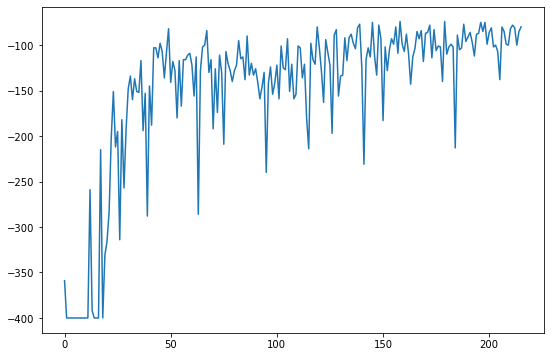

In [ ]:
nature.score_to_beat = -100

agent.env = gym.make('Acrobot-v1')
agent.env.seed(0)

try:
  nature.evolve(exploration_profile,verbose=True,render_every=100,fps=50, min_score=-400)
except KeyboardInterrupt:
  print('\n\nTraining interrupted\n\n')
agent.env.close()

plt.figure(figsize=(9,6))
plt.plot(nature.score_log)

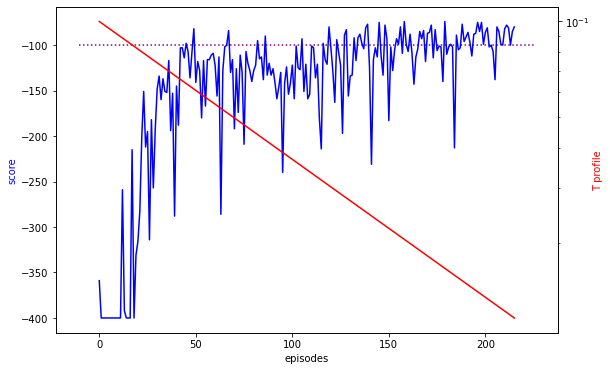

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(nature.score_log, color='blue')
# ax.plot(nature.cumulated_reward_log, color='cyan')
# ax.plot(np.convolve(nature.score_log, np.ones(10)/10), color='cyan')
ax.set_ylabel('score', color='blue')
ax.set_xlabel('episodes')

ax2 = ax.twinx()
ax2.semilogy(exploration_profile.profile[:len(nature.score_log)], color='red')
ax2.set_ylabel('T profile', color='red')

ax.hlines([nature.score_to_beat], *ax.get_xlim(), color='purple', linestyle='dotted')

In [ ]:
scores = []
motorized_actions_percs = []
for i in range(100):
  states, qvalues = agent.run_episode(beta=0., render=True, fps=50, debug=True, modifier=default_modifier_acrobot)
  actions = [int(q.argmax()) for q in qvalues]
  a = np.array(actions) - 1
  motorized_actions_perc = -np.sum(np.abs(a))/agent.score
  print(f'{motorized_actions_perc = }')
  scores.append(agent.score)
  motorized_actions_percs.append(motorized_actions_perc)
agent.env.close()

final score: -101
motorized_actions_perc = 0.8118811881188119
final score: -78
motorized_actions_perc = 0.8589743589743589
final score: -81
motorized_actions_perc = 0.8518518518518519
final score: -78
motorized_actions_perc = 0.8461538461538461
final score: -105
motorized_actions_perc = 0.8761904761904762
final score: -116
motorized_actions_perc = 0.7931034482758621
final score: -121
motorized_actions_perc = 0.8677685950413223
final score: -84
motorized_actions_perc = 0.8452380952380952
final score: -82
motorized_actions_perc = 0.8780487804878049
final score: -81
motorized_actions_perc = 0.8518518518518519
final score: -111
motorized_actions_perc = 0.7837837837837838
final score: -106
motorized_actions_perc = 0.7924528301886793
final score: -97
motorized_actions_perc = 0.8969072164948454
final score: -87
motorized_actions_perc = 0.8850574712643678
final score: -108
motorized_actions_perc = 0.9074074074074074
final score: -88
motorized_actions_perc = 0.8863636363636364
final score: -80


In [ ]:
print(np.mean(scores))
print(np.mean(motorized_actions_percs))

-95.55
0.8392830110386297


In [ ]:
agent.env = EnvWrapper(gym.make('Acrobot-v1'), './videos/acrobot_mod_r_bad.mp4')
agent.run_episode(fps=50,render=True, modifier=default_modifier_acrobot)
agent.env.close()

final score: -105


### Adding a cost to using the motor

In [ ]:
net_params = {'Ni': state_space_dim, 'Nhs': [128, 128], 'No': action_space_dim, 'activation_function': nn.Tanh}

policy_net = FCN(**net_params)
target_net = FCN(**net_params)

agent = Agent(None,policy_net,policy=softmax_policy) # for now set the env to None

evolver_params = {'agent': agent, 'target_net': target_net, 'optimizer_type': optim.SGD, 'optimizer_params': {'lr': 1e-3},
                  'loss_function': nn.SmoothL1Loss(), 'batch_size': 128,
                  'height_weight': 0.9, 'height_exponent': 0.3, 'end_state_penalty': 10,
                  'motor_cost': 0.3, 'discount_rate': 0.99,
                  'update_target_net_every': 10, 'score_to_beat': -100}

nature = Evolver_a(**evolver_params)

FCN initialized
Shape flow:  [6, 128, 128, 3]
FCN initialized
Shape flow:  [6, 128, 128, 3]


In [ ]:
exploration_profile = ExpExplorationProfile(start_value=0.1, lam=10)

Episode 0: beta = 1.000e-01, final score: -400
Updating target net
Episode 1: beta = 9.900e-02, final score: -400
Episode 2: beta = 9.802e-02, 

Initiating learning


final score: -400
Episode 3: beta = 9.704e-02, final score: -400
Episode 4: beta = 9.608e-02, final score: -400
Episode 5: beta = 9.512e-02, final score: -400
Episode 6: beta = 9.418e-02, final score: -400
Episode 7: beta = 9.324e-02, final score: -400
Episode 8: beta = 9.231e-02, final score: -400
Episode 9: beta = 9.139e-02, final score: -400
Episode 10: beta = 9.048e-02, final score: -400
Updating target net
Episode 11: beta = 8.958e-02, final score: -400
Episode 12: beta = 8.869e-02, final score: -400
Episode 13: beta = 8.781e-02, final score: -400
Episode 14: beta = 8.694e-02, final score: -355
Episode 15: beta = 8.607e-02, final score: -400
Episode 16: beta = 8.521e-02, final score: -400
Episode 17: beta = 8.437e-02, final score: -400
Episode 18: beta = 8.353e-02, final score: -400
Episode 19: beta = 8.270e-02, fina

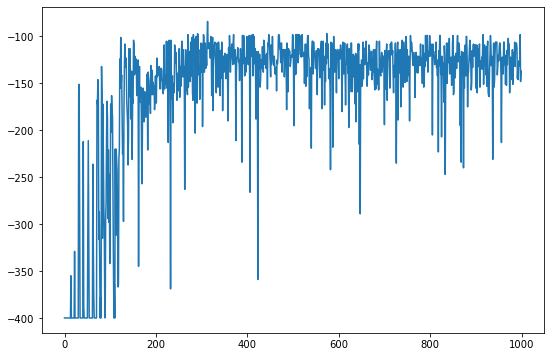

In [ ]:
nature.score_to_beat = -100

agent.env = gym.make('Acrobot-v1')
agent.env.seed(0)

try:
  nature.evolve(exploration_profile,verbose=True,render_every=100,fps=50, min_score=-400)
except KeyboardInterrupt:
  print('\n\nTraining interrupted\n\n')
agent.env.close()

plt.figure(figsize=(9,6))
plt.plot(nature.score_log)

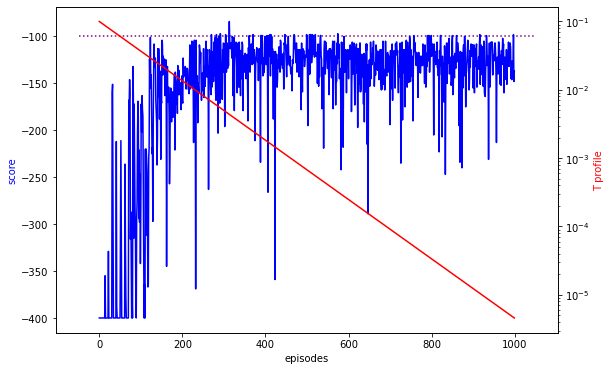

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(nature.score_log, color='blue')
# ax.plot(nature.cumulated_reward_log, color='cyan')
# ax.plot(np.convolve(nature.score_log, np.ones(10)/10), color='cyan')
ax.set_ylabel('score', color='blue')
ax.set_xlabel('episodes')

ax2 = ax.twinx()
ax2.semilogy(exploration_profile.profile[:len(nature.score_log)], color='red')
ax2.set_ylabel('T profile', color='red')

ax.hlines([nature.score_to_beat], *ax.get_xlim(), color='purple', linestyle='dotted')

In [ ]:
scores = []
motorized_actions_percs = []
for i in range(100):
  states, qvalues = agent.run_episode(beta=0., render=True, fps=50, debug=True, modifier=default_modifier_acrobot)
  actions = [int(q.argmax()) for q in qvalues]
  a = np.array(actions) - 1
  motorized_actions_perc = -np.sum(np.abs(a))/agent.score
  print(f'{motorized_actions_perc = }')
  scores.append(agent.score)
  motorized_actions_percs.append(motorized_actions_perc)
agent.env.close()

final score: -140
motorized_actions_perc = 0.42142857142857143
final score: -121
motorized_actions_perc = 0.5041322314049587
final score: -142
motorized_actions_perc = 0.43661971830985913
final score: -135
motorized_actions_perc = 0.4888888888888889
final score: -136
motorized_actions_perc = 0.49264705882352944
final score: -140
motorized_actions_perc = 0.4714285714285714
final score: -107
motorized_actions_perc = 0.4392523364485981
final score: -107
motorized_actions_perc = 0.4485981308411215
final score: -500
motorized_actions_perc = 0.874
final score: -126
motorized_actions_perc = 0.4365079365079365
final score: -107
motorized_actions_perc = 0.4392523364485981
final score: -108
motorized_actions_perc = 0.46296296296296297
final score: -149
motorized_actions_perc = 0.4966442953020134
final score: -133
motorized_actions_perc = 0.5338345864661654
final score: -126
motorized_actions_perc = 0.5079365079365079
final score: -109
motorized_actions_perc = 0.47706422018348627
final score: -10

In [ ]:
print(np.mean(scores))
print(np.mean(motorized_actions_percs))

-133.58
0.47737029088326766


In [ ]:
agent.env = EnvWrapper(gym.make('Acrobot-v1'), './videos/acrobot_motor_cost0.3_eh0.3.mp4')
agent.run_episode(fps=50,render=True, modifier=default_modifier_acrobot)
agent.env.close()

final score: -98
